<a href="https://colab.research.google.com/github/sayanbanerjee32/stable-diffusion-texual-inversion-demo/blob/main/SD_textual_inversion_guidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate open_clip_torch

In [ ]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
# from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import open_clip

import torch.nn.functional as F
from torchvision import transforms

torch.manual_seed(1)
# if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

from huggingface_hub import hf_hub_download

In [ ]:
prompt = 'A mouse in the style of puppy'
stl_list = [
            'birb-style',
            'cute-game-style',
            'depthmap',
            'line-art',
            'low-poly-hd-logos-icons'
            ]

In [ ]:
for stl in stl_list:
    if not os.path.exists(stl):
        os.mkdir(stl)
    hf_hub_download(repo_id=f"sd-concepts-library/{stl}", filename="learned_embeds.bin", local_dir=f"./{stl}")

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model = clip_model.to(torch_device)
clip_model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Guidance

In [ ]:
## blue loss
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

In [ ]:
# hue loss
def rgb_to_hsv(image):
    r, g, b = image[:, 0, :, :], image[:, 1, :, :], image[:, 2, :, :]
    maxc = torch.max(image, dim=1)[0]
    minc = torch.min(image, dim=1)[0]

    v = maxc
    s = (maxc - minc) / (maxc + 1e-10)
    deltac = maxc - minc

    # Initialize hue
    h = torch.zeros_like(maxc)

    mask = maxc == r
    h[mask] = ((g - b) / deltac)[mask] % 6

    mask = maxc == g
    h[mask] = ((b - r) / deltac)[mask] + 2

    mask = maxc == b
    h[mask] = ((r - g) / deltac)[mask] + 4

    h = h / 6  # Normalize to [0, 1]
    h[deltac == 0] = 0  # If no color difference, set hue to 0

    return torch.stack([h, s, v], dim=1)


def hue_loss(images, target_hue=0.5):
    # Convert the images to HSV color space
    hsv_images = rgb_to_hsv(images)

    # Extract the hue channel
    hue = hsv_images[:, 0, :, :]

    # Calculate the error as the mean absolute deviation from the target hue
    error = torch.abs(hue - target_hue).mean()

    return error


In [ ]:
def get_text_embedding(text):
    text_tokens = clip_tokenizer([text]).to(torch_device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = clip_model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

def get_image_embedding(image):
    image_input = clip_preprocess(image).unsqueeze(0).to(torch_device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(image_input).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

def text_image_similarity_loss(generated_images, target_text = "plain background"):
    # Get text embedding
    text_embedding = get_text_embedding(target_text)

    # Ensure the generated_images have requires_grad=True
    # generated_images.requires_grad_(True)

    # Convert image tensor to the required format (normalization, resizing)
    # Normalize the images (assuming they are in [0, 1])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Example size, modify as needed
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformation
    transformed_images = transform(generated_images)

    # Assuming `image_encoder` is a pretrained model that returns image embeddings
    # Get image embeddings
    # image_embeddings = image_encoder(generated_images)
    with torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(transformed_images).float()
        norm_image_features = image_features / image_features.norm(dim=-1, keepdim=True)


    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(norm_image_features, text_embedding, dim=-1)

    # Define the loss as 1 - cosine similarity (assuming we want to maximize similarity)
    loss = 1 - cos_sim.mean()

    return loss

# Note: Ensure the `image_encoder` and `generated_images` are compatible in terms of input dimensions.



In [ ]:
def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    # pil_images = [Image.fromarray(img).resize(target_size, Image.ANTIALIAS) for img in images]
    return pil_images

In [ ]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

torch.autograd.set_detect_anomaly(True)
#Generating an image with these modified embeddings
def generate_with_embs(text_embeddings, loss_fn = None, loss_scale = 200, guidance_scale = 20,
                       seed_value = 1, num_inference_steps = 30, additional_guidence = False):
    height = 256                        # default height of Stable Diffusion
    width = 256                         # default width of Stable Diffusion
    # num_inference_steps = 50            # Number of denoising steps
                   # Scale for classifier-free guidance
    generator = torch.manual_seed(seed_value)   # Seed generator to create the inital latent noise
    batch_size = 1


    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if (i%5 == 0 or i == len(scheduler.timesteps) -1)and additional_guidence:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            loss = loss_fn(denoised_images) * loss_scale

            # Occasionally print it out
            if i%10==0 or i == len(scheduler.timesteps) -1:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            # latents = latents.detach() - cond_grad * sigma**2
            latents = latents - cond_grad * sigma**2

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

        # Ensure the latents do not lose the grad tracking
        # latents.requires_grad_()

    # return latents_to_pil(latents, target_size=(height, width))[0]
    return latents_to_pil(latents)[0]


In [ ]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [ ]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
token_emb_layer, pos_emb_layer  # Vocab size 49408, emb_dim 768

(Embedding(49408, 768), Embedding(77, 768))

In [ ]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [ ]:
# birb_embed = torch.load('learned_embeds.bin')
# birb_embed.keys(),birb_embed['<midjourney-style>'].shape

<ipython-input-10-1f3ca1b9f30a>:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

Style: birb-style - without additional guidence


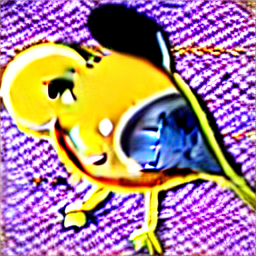

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 53.720272064208984
10 loss: 24.103052139282227
20 loss: 21.56041145324707
29 loss: 20.30396842956543
Style: birb-style - with additional guidence


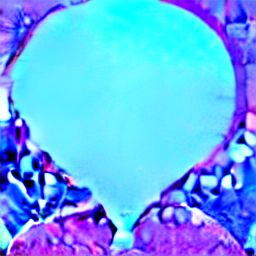

  0%|          | 0/30 [00:00<?, ?it/s]

Style: cute-game-style - without additional guidence


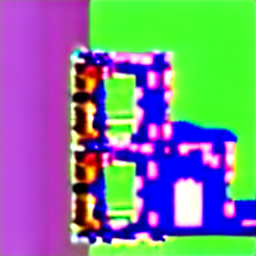

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 55.704833984375
10 loss: 21.65180778503418
20 loss: 20.07756233215332
29 loss: 19.357913970947266
Style: cute-game-style - with additional guidence


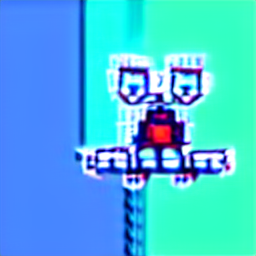

  0%|          | 0/30 [00:00<?, ?it/s]

Style: depthmap - without additional guidence


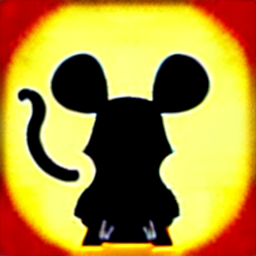

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 66.36385345458984
10 loss: 44.99900817871094
20 loss: 39.68447494506836
29 loss: 38.81822204589844
Style: depthmap - with additional guidence


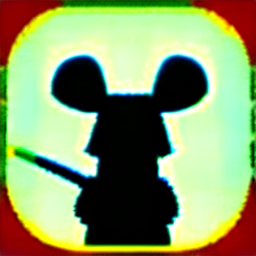

  0%|          | 0/30 [00:00<?, ?it/s]

Style: line-art - without additional guidence


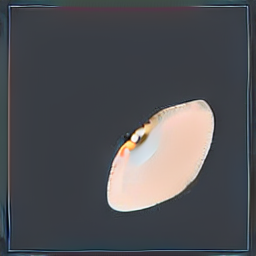

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 43.90778732299805
10 loss: 7.730012893676758
20 loss: 5.129704475402832
29 loss: 4.943314552307129
Style: line-art - with additional guidence


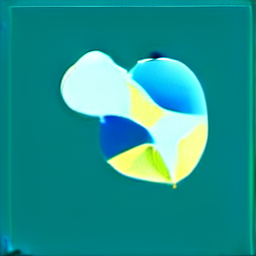

  0%|          | 0/30 [00:00<?, ?it/s]

Style: low-poly-hd-logos-icons - without additional guidence


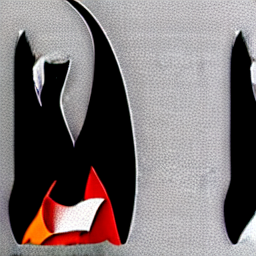

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 54.80583190917969
10 loss: 9.887001991271973
20 loss: 6.1536478996276855
29 loss: 6.374910354614258
Style: low-poly-hd-logos-icons - with additional guidence


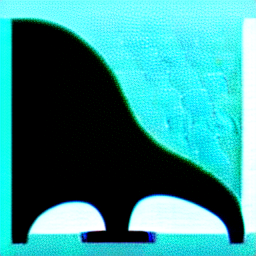

In [ ]:
# Tokenize
text_input = tokenizer(prompt, padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

for i, stl in enumerate(stl_list):
    stl_embed = torch.load(f'{stl}/learned_embeds.bin')

    # The new embedding - our special birb word
    replacement_token_embedding = stl_embed[f'<{stl}>'].to(torch_device)

    # Insert this into the token embeddings
    token_embeddings[0, min(torch.where(input_ids[0]==tokenizer.eos_token_id)[0]) - 1] = replacement_token_embedding.to(torch_device)

    # Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    pil_im = generate_with_embs(modified_output_embeddings, seed_value = i,
                                additional_guidence = False)
    print(f"Style: {stl} - without additional guidence")
    display(pil_im)

    pil_im = generate_with_embs(modified_output_embeddings,loss_fn = hue_loss, #text_image_similarity_loss,
                                additional_guidence = True,
                                seed_value = i)
    print(f"Style: {stl} - with additional guidence")
    display(pil_im)